In [ ]:
from tensorflow.keras.layers import Dense, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import clear_output
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model
import random
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!unzip -q '/content/drive/MyDrive/bases/lfw_attributes.txt.zip' -d '/content/lfw_funneled'
!unzip -q '/content/drive/MyDrive/bases/lfw_funneled.zip' -d '/content/lfw_funneled_2'

In [ ]:
attr_error = pd.read_csv('/content/lfw_funneled/lfw_attributes.txt',sep='\t', header=1)
names = attr_error.columns[1:]
values = attr_error.values[:,:-1]
attr = pd.DataFrame(data=values, columns=names)
attr.person = [attr.iloc[i,0].replace(' ','_') for i in range(attr.shape[0])]

path = '/content/lfw_funneled_2/lfw_funneled/'
la_dim, lr =  2048, 1e-4
dsc = 128
cond,exp_c = attr.shape[1]-2, 5
attr.head()

,person,imagenum,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,Aaron_Eckhart,1,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,Aaron_Guiel,1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,Aaron_Patterson,1,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,Aaron_Peirsol,1,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,Aaron_Peirsol,2,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.1

**Модель автокодировщика с условием для дальнейшей генерации с переносом стиля.**

In [ ]:
def sampling(args):
    [mu, log_sigma] = args
    z = mu + tf.multiply(tf.sqrt(tf.exp(log_sigma)),tf.random.normal(shape=(tf.shape(log_sigma))))
    return z

l1=2e-5
l2=2e-4

input_enc =  Input((dsc, dsc, 3))
input_c =  Input((cond*exp_c))
x1 = Conv2D(1, kernel_size=4, padding='same', activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(input_enc)
x2 = Conv2D(1, kernel_size=2, padding='same', activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(input_enc)
x3 = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(input_enc)
enc = concatenate([x1,x2,x3])

enc = Conv2D(64, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc = Conv2D(128, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc = Conv2D(256, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc = Conv2D(512, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc = Conv2D(1024, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc_shape = (4,4,1024)
enc = GlobalMaxPooling2D()(enc)
enc = Dense(1024,activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc = Dense(512,activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
enc = concatenate([enc,input_c])

mu = Dense(la_dim, activation = 'softplus', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)
log_sigma = Dense(la_dim, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(enc)

latent = Lambda(sampling, output_shape=(la_dim,))([mu, log_sigma])

encoder  = Model([input_enc,input_c], latent, name = 'Encoder')
mu_mean = Model([input_enc,input_c], mu, name = 'Enc_mu')


input_dec, input_cd = Input((la_dim)), Input((cond*exp_c), dtype='float32')
dec_lat = Dense(512,activation = 'elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(input_dec)
dec_lat = Dense(1024,activation = 'elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec_lat)
dec = concatenate([dec_lat,input_cd])
dec = Dense(np.prod(np.array(enc_shape)),activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Reshape(enc_shape)(dec)
dec = Conv2DTranspose(512, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2D(512, kernel_size=4, padding='same', activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2DTranspose(256, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2D(256, kernel_size=4, padding='same', activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2DTranspose(128, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2D(128, kernel_size=4, padding='same', activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2DTranspose(64, kernel_size=4, padding='same', strides = 2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2D(64, kernel_size=4, padding='same', activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
dec = Conv2DTranspose(32, kernel_size=4, padding='same', strides=2, activation='elu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
x1 = Conv2D(1, kernel_size=4, padding='same', activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
x2 = Conv2D(1, kernel_size=2, padding='same', activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
x3 = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(dec)
output_dec = concatenate([x1,x2,x3])

decoder = Model([input_dec,input_cd], output_dec, name='Decoder')
cvae = Model([input_enc, input_c, input_cd], decoder([encoder([input_enc,input_c]),input_cd]), name='CVAE')
style = Model([input_enc, input_c, input_cd],decoder([mu_mean([input_enc, input_c]), input_cd] ),name='Style')


def vae_loss(x, decoded):
    kl_divergence = tf.reduce_sum(tf.keras.metrics.kullback_leibler_divergence(x, decoded), axis=[1, 2])
    x = tf.reshape(x, shape=(-1, 3*dsc*dsc))
    decoded = tf.reshape(decoded, shape=(-1, 3*dsc*dsc))
    reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(decoded,  scale_diag=[tf.repeat(0.05,tf.shape(x)[1])]).log_prob(x))
    cost = tf.reduce_mean(reconstruction_term + kl_divergence)
    return cost



def plot_images(*args, expand = 2):
    n = min([x.shape[0] for x in args])
    layer = np.zeros((dsc * len(args), dsc * n,args[0].shape[3]))
    for ch in range(args[0].shape[3]):
      for i in range(n):
        for j in range(len(args)):
          layer[j*dsc:(j + 1)*dsc,i*dsc:(i + 1)*dsc,ch] = args[j][i,:,:,ch]

    plt.figure(figsize=(expand*n, expand*len(args)))
    plt.imshow(layer)

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.show()

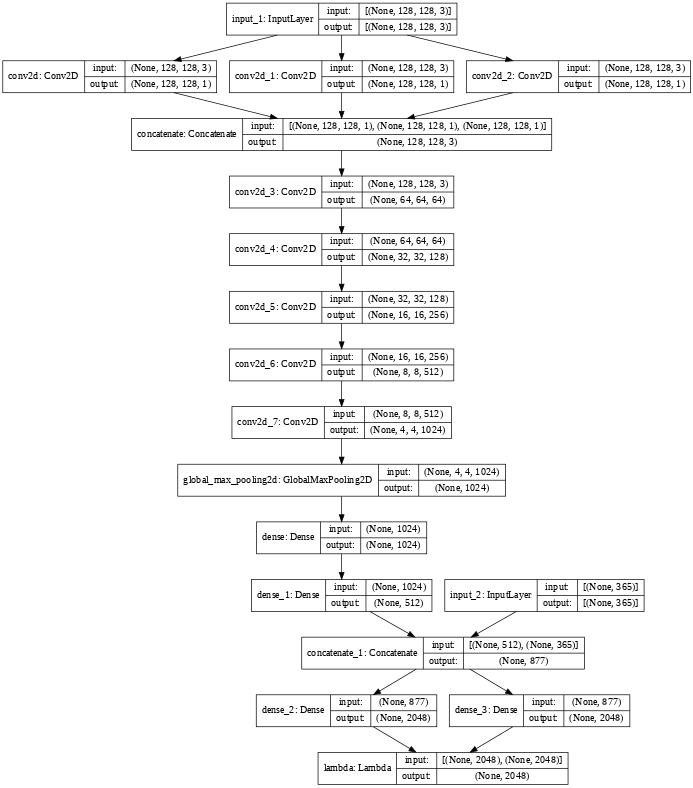

In [ ]:
plot_model(encoder, show_shapes=True, dpi=50)

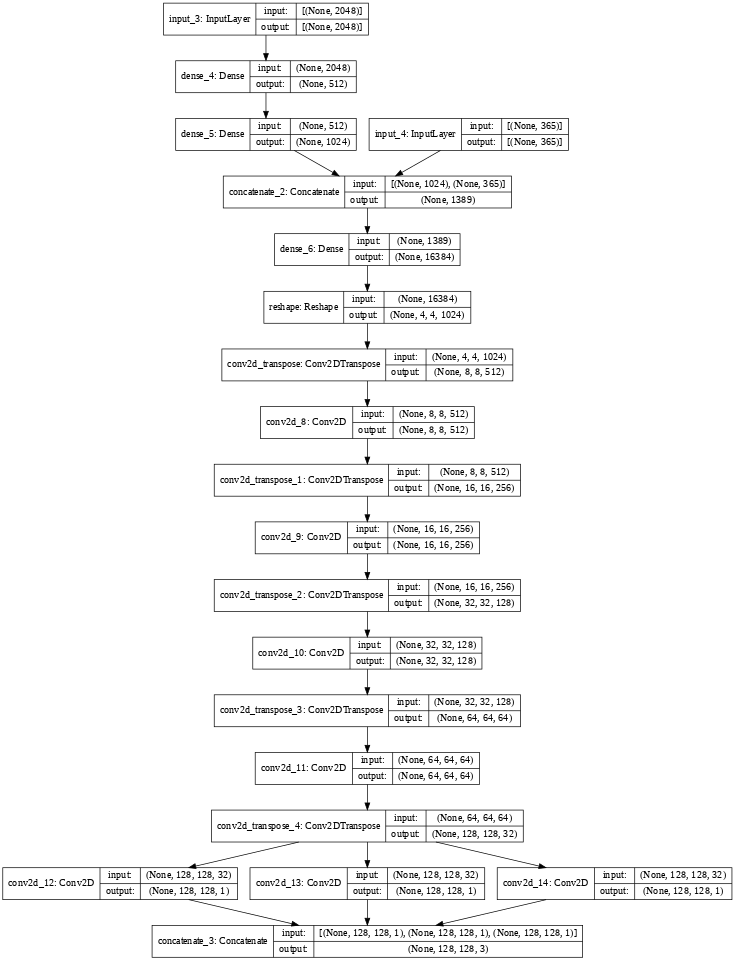

In [ ]:
plot_model(decoder, show_shapes=True, dpi=50)

In [ ]:
x_train = []
y_train = []

ind_list = (list(range(0,8000)))
random.shuffle(ind_list)
for i in ind_list:
    img_uri = f'{path}{attr.iloc[i,0]}/{attr.iloc[i,0]}_{"%04d" % attr.iloc[i,1]}.jpg'
    img = image.load_img(img_uri, target_size=(dsc, dsc))
    X = np.array(img) / 255
    C = np.repeat(np.array(attr.iloc[i,2:].values),exp_c)

    x_train.append(X)
    y_train.append(C)

x_train = np.array(x_train)
y_train = np.array(y_train).astype('float32')

In [ ]:
def on_epoch_end(epoch, logs):
    if epoch%5==0:
        clear_output(wait=True)
        decoded = cvae.predict([x_train[:10],y_train[:10],y_train[:10]])
        show_list = np.arange(10)
        plot_images(x_train[show_list],decoded[show_list])
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

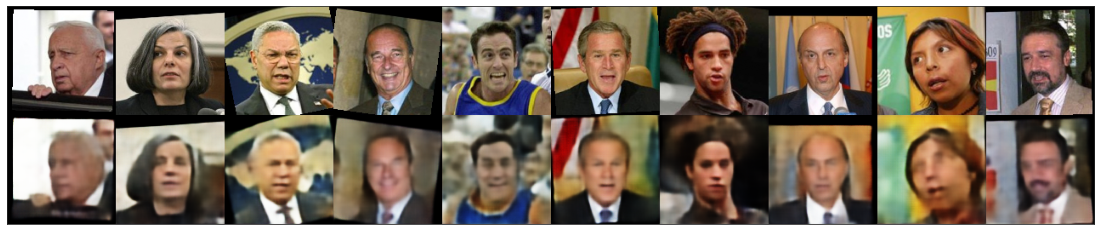

Epoch 47/50
250/250 [==============================] - 33s 132ms/step - loss: -1702983.3750
Epoch 48/50
250/250 [==============================] - 33s 132ms/step - loss: -1768774.6250
Epoch 49/50
250/250 [==============================] - 33s 132ms/step - loss: -1798854.1250
Epoch 50/50
250/250 [==============================] - 33s 132ms/step - loss: -1700656.7500


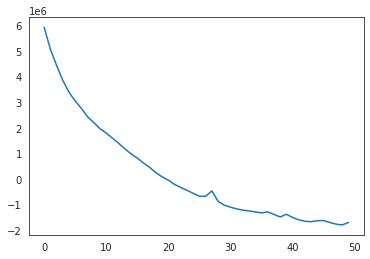

In [ ]:
lr = 8e-5
cvae.compile(optimizer=Adam(learning_rate=lr), loss=vae_loss)
history = cvae.fit((x_train,y_train,y_train),x_train, epochs=50, callbacks=[pltfig])
plt.plot(history.history['loss'], label = 'Ошибка')
plt.show()

In [ ]:
z_imgs = encoder.predict([x_train[:500], y_train[:500]], batch_size=500)
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):

  index_1 = int(round(z_imgs.shape[0]*np.random.sample(1)[0]))
  index_2 = int(round(z_imgs.shape[0]*np.random.sample(1)[0]))
  noise_1 = z_imgs[index_1]
  noise_2 = z_imgs[index_2]
  class_1 = y_train[index_1]
  class_2 = y_train[index_2]
  im_arr = [decoder.predict([(i*noise_2/(examples-1) + (examples-i-1)*noise_1/(examples-1))[None], (i*class_2/(examples-1) + (examples-i-1)*class_1/(examples-1))[None]]) for i in range(examples)]
  im_arr = np.array(im_arr)
  im_arr = im_arr.squeeze()
  plt.figure(figsize=figsize)
  for i in range(im_arr.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
    plt.axis('off')
  plt.tight_layout()

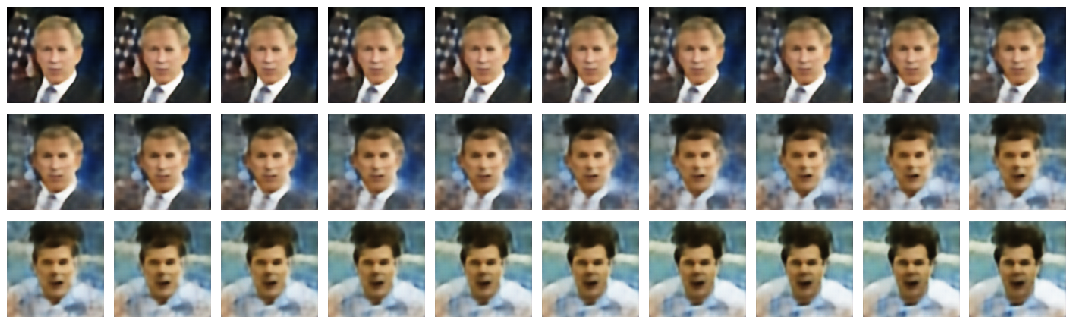

In [ ]:
plot_images_two_points(decoder, 30)